In [1]:
import pandas as pd
import sys
sys.path.append("..")
import utils
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations 
from scipy.stats import rankdata
from scipy.stats import linregress

In [2]:
def get_binned_df_list(df, binning_list):
    bin_range = binning_list[-1]
    df_by_chunk = []
    for bin_range in binning_list:
        df_test = df.loc[(df.mean_rating >= bin_range[0]) & (df.mean_rating < bin_range[1])]
        df_by_chunk.append(df_test)
        
    return df_by_chunk


def df_preprocessing(df):
    df["mean_rating"] = [np.mean(rating) for rating in df.rating]
    df["var_rating"] = [np.var(rating) for rating in df.rating]
    df["std_rating"] = [np.std(rating) for rating in df.rating]
    df["number_of_ratings"] = [len(r) for r in df.rating]
    df = df.loc[df.number_of_ratings > 1].reset_index(drop=True)

    return df

In [4]:
df_20 = pd.read_pickle("../data/ICLR2020/ICLR2020_preprocessed_table.pkl")
df_19 = pd.read_pickle("../data/ICLR2019/ICLR2019_preprocessed_table.pkl")
df_18 = pd.read_pickle("../data/ICLR2018/ICLR2018_preprocessed_table.pkl")
df_17 = pd.read_pickle("../data/ICLR2017/ICLR2017_preprocessed_table.pkl")

# calculating var&mean ratings, removing papers w/ num of ratings < 2
dfs = {"17": df_preprocessing(df_17),
       "18": df_preprocessing(df_18),
       "19": df_preprocessing(df_19),
       "20": df_preprocessing(df_20)}

In [5]:
df_17

,decision,title,authors,rating,citations,mean_rating,var_rating,std_rating,numer_of_ratings
0,Accept (Poster),Outrageously Large Neural Networks: The Spars...,"[Noam Shazeer, *Azalia Mirhoseini, *Krzysztof ...","[7, 6, 7]",870.0,6.666667,0.222222,0.471405,3
1,Invite to Workshop Track,Charged Point Normalization: An Efficient Solu...,[Armen Aghajanyan],"[5, 4, 4]",0.0,4.333333,0.222222,0.471405,3
2,Accept (Poster),Bidirectional Attention Flow for Machine Compr...,"[Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi,...","[7, 8, 8]",1690.0,7.666667,0.222222,0.471405,3
3,Accept (Poster),Dynamic Coattention Networks For Question Answ...,"[Caiming Xiong, Victor Zhong, Richard Socher]","[8, 8, 8]",582.0,8.000000,0.000000,0.000000,3
4,Accept (Poster),Exploring Sparsity in Recurrent Neural Networks,"[Sharan Narang, Greg Diamos, Shubho Sengupta, ...","[7, 6]",239.0,6.500000,0.250000,0.500000,2
...,...,...,...,...,...,...,...,...,...
240,Accept (Poster),Adversarially Learned Inference,"[Vincent Dumoulin, Ishmael Belghazi, Ben Poole...","[7, 7, 8]",1272.0,7.333333,0.222222,0.471405,3
241,Accept (Poster),Multi-view Recurrent Neural Acoustic Word Embe...,"[Wanjia He, Weiran Wang, Karen Livescu]","[5, 6, 6]",75.0,5.666667,0.222222,0.471405,3
242,Invite to Workshop Track,Recursive Regression with Neural Networks: App...,"[Vicenç Rubies Royo, Claire Tomlin]","[7, 3, 5]",8.0,5.000000,2.666667,1.632993,3
243,Accept (Poster),Recurrent Environment Simulators,"[Silvia Chiappa, Sébastien Racaniere, Daan Wie...","[7, 5, 8]",169.0,6.666667,1.555556,1.247219,3


### mean_rating vs citations 

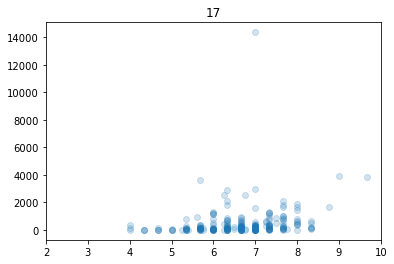

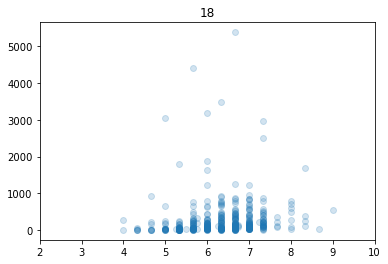

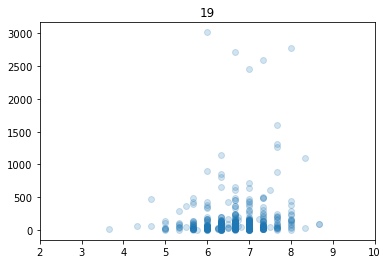

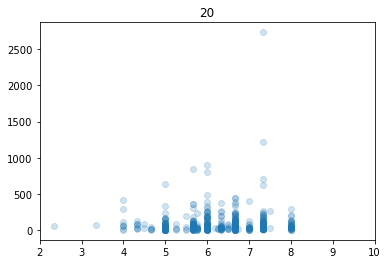

In [20]:
for year in ["17", "18", "19", "20"]:
    test_df = dfs[year]
    plt.scatter(test_df.mean_rating, test_df.citations, alpha=0.2)
#     plt.yscale("symlog")
    plt.title(year)
    plt.xlim(2, 10)
    plt.show()

### mean_rating vs citations in log scale
* why setting log scale in citations? -> The distribution of citations follows power-law

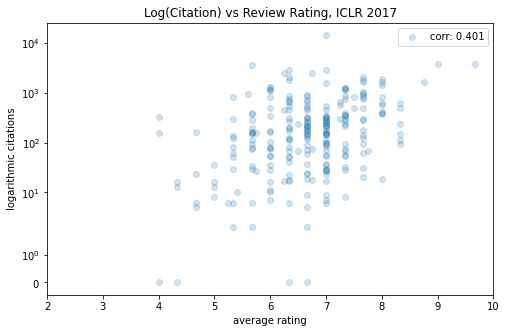

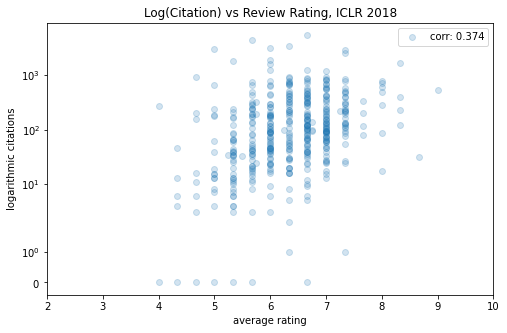

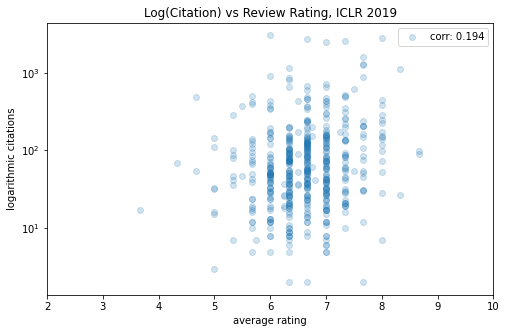

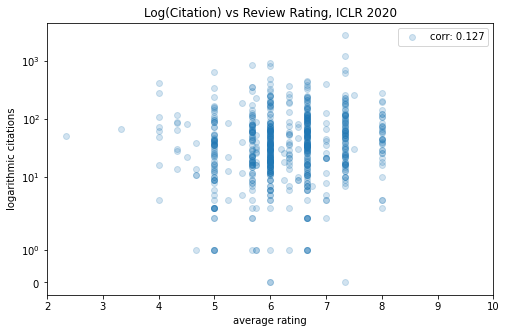

In [9]:
for year in ["17", "18", "19", "20"]:
    
    plt.figure(figsize=(8, 5))
    test_df = dfs[year]
    r = linregress(test_df.mean_rating, np.log(test_df.citations+1)).rvalue
    
    plt.scatter(test_df.mean_rating, test_df.citations, alpha=0.2, label=f"corr: {round(r, 3)}")
    plt.yscale("symlog")
    plt.title(f"Log(Citation) vs Review Rating, ICLR 20{year}")
    plt.xlabel("average rating")
    plt.ylabel("logarithmic citations")
    plt.xlim(2, 10)
    plt.legend()
    plt.savefig(f"./Log_Citation_vs_Review_Rating_ICLR_20{year}.png")
    plt.show()

# TODO: pearson corr -> rating vs logged citation
# log에 대한 당위성 서술해야함. 

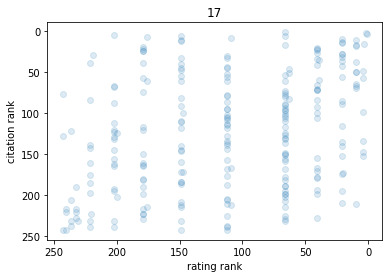

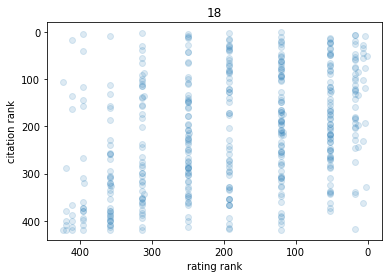

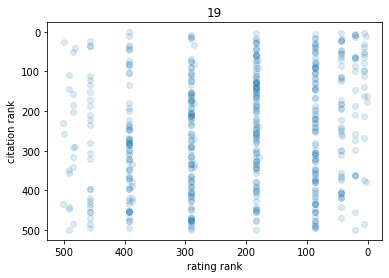

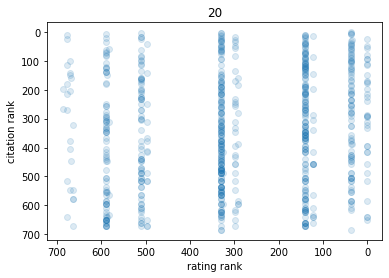

In [44]:
for year in ["17", "18", "19", "20"]:
    test_df = dfs[year]
    rating_rank = rankdata(-np.array(test_df.mean_rating.to_list()), method='min')
    citation_rank = rankdata(-np.array(test_df.citations.to_list()), method='min')
    plt.scatter(rating_rank, citation_rank, alpha=0.15)
#     plt.yscale("symlog")
    plt.title(year)
    plt.xlabel("rating rank")
    plt.ylabel("citation rank")
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

### Pearson correlation

In [14]:
for year in ["17", "18", "19", "20"]:
    test_df = dfs[year]
    r = linregress(test_df.mean_rating, test_df.citations).rvalue
    print(f"20{year} pearson corr: ", round(r, 3))

2017 pearson corr:  0.196
2018 pearson corr:  0.111
2019 pearson corr:  0.145
2020 pearson corr:  0.079


In [19]:
for year in ["17", "18", "19", "20"]:
    test_df = dfs[year]
    r = linregress(test_df.mean_rating, np.log(test_df.citations+1)).rvalue
    print(f"20{year} pearson corr: ", round(r, 3))

2017 pearson corr:  0.401
2018 pearson corr:  0.374
2019 pearson corr:  0.194
2020 pearson corr:  0.127


In [45]:
# from https://openreview.net/forum?id=Cn706AbJaKW 
for year in ["17", "18", "19", "20"]:
    test_df = dfs[year]
    rating_rank = rankdata(-np.array(test_df.mean_rating.to_list()), method='min')
    citation_rank = rankdata(-np.array(test_df.citations.to_list()), method='min')
    
    r = linregress(rating_rank, citation_rank).rvalue
    print(f"20{year} pearson corr: ", round(r, 3))

2017 pearson corr:  0.339
2018 pearson corr:  0.357
2019 pearson corr:  0.182
2020 pearson corr:  0.142


#### 재밌는 점: 점점 correlation score가 낮아진다?
* 추정1. 해가 거듭할수록 페이퍼 수가 많아졌고, 더 많은 리뷰어들이 리뷰에 참여해야 하여 리뷰의 질적 수준이 하락함. 
* 추정2. 해가 거듭할수록 페이퍼 수가 많아졌고, 리뷰어당 더 많은 리뷰를 해야해서 질적 수준이 하락함. 
    * 이거 확인할 수도 있을듯? 
* 추정3. 19, 20년 논문들은 인용 관점에서 아직 제대로 평가가 되지 않았다. citation 분포가 명확해지려면 더 많은 시간이 필요함. 
    * 간접검증하려면 2017, 2018 논문들의 citation 정보를 시간대별로 알아야 함. 
    * https://horace.io/OpenReviewExplorer/?conf=iclr2017 -> 4년전 인용 데이터로 분석해볼까

#### https://openreview.net/forum?id=Cn706AbJaKW 이런..이미 논문이 있었군.. "An Open Review of OpenReview: A Critical Analysis of the Machine Learning Conference Review Process" 심지어 ICLR2021에 submit됨.(당근 리젝이지만)

## https://horace.io/OpenReviewExplorer/?conf=iclr2017 -> 4년전 인용 데이터로 분석해볼까


In [2]:
import json
with open("../data/iclr2017_old.json", "r") as f:
    iclr17old = json.load(f)

In [14]:
df17old = pd.json_normalize(iclr17old)

In [17]:
# dfs["17"]
df17old = df17old.loc[df17old.decision != "Reject"].reset_index(drop=True)

In [18]:
# dfs["17"]

In [23]:
df17old.head(1)

,url,decision,ratings,rating,confidences,abstract,title,rank,citations,karpathy,variance,authors,emails
0,https://openreview.net/forum?id=Sy8gdB9xx,Accept (Oral),"[10, 9, 10]",9.73,"[4, 3, 4]","Despite their massive size, successful deep ar...",Understanding deep learning requires rethinkin...,1,152,38,0.47,"[Chiyuan Zhang, Samy Bengio, Moritz Hardt, Ben...","[berkeley.edu, google.com, mit.edu]"


In [24]:
dfs["17"].loc[dfs["17"].title == df17old.title[0], "citations_old"] = df17old.citations[0]

In [26]:
for i, row in df17old.iterrows():
    dfs["17"].loc[dfs["17"].title == row.title, "citations_old"] = row.citations

In [27]:
dfs["17"]

,decision,title,authors,rating,citations,mean_rating,var_rating,std_rating,numer_of_ratings,citations_old
0,Accept (Poster),Outrageously Large Neural Networks: The Spars...,"[Noam Shazeer, *Azalia Mirhoseini, *Krzysztof ...","[7, 6, 7]",870.0,6.666667,0.222222,0.471405,3,46.0
1,Invite to Workshop Track,Charged Point Normalization: An Efficient Solu...,[Armen Aghajanyan],"[5, 4, 4]",0.0,4.333333,0.222222,0.471405,3,0.0
2,Accept (Poster),Bidirectional Attention Flow for Machine Compr...,"[Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi,...","[7, 8, 8]",1690.0,7.666667,0.222222,0.471405,3,112.0
3,Accept (Poster),Dynamic Coattention Networks For Question Answ...,"[Caiming Xiong, Victor Zhong, Richard Socher]","[8, 8, 8]",582.0,8.000000,0.000000,0.000000,3,110.0
4,Accept (Poster),Exploring Sparsity in Recurrent Neural Networks,"[Sharan Narang, Greg Diamos, Shubho Sengupta, ...","[7, 6]",239.0,6.500000,0.250000,0.500000,2,8.0
...,...,...,...,...,...,...,...,...,...,...
240,Accept (Poster),Adversarially Learned Inference,"[Vincent Dumoulin, Ishmael Belghazi, Ben Poole...","[7, 7, 8]",1272.0,7.333333,0.222222,0.471405,3,122.0
241,Accept (Poster),Multi-view Recurrent Neural Acoustic Word Embe...,"[Wanjia He, Weiran Wang, Karen Livescu]","[5, 6, 6]",75.0,5.666667,0.222222,0.471405,3,9.0
242,Invite to Workshop Track,Recursive Regression with Neural Networks: App...,"[Vicenç Rubies Royo, Claire Tomlin]","[7, 3, 5]",8.0,5.000000,2.666667,1.632993,3,1.0
243,Accept (Poster),Recurrent Environment Simulators,"[Silvia Chiappa, Sébastien Racaniere, Daan Wie...","[7, 5, 8]",169.0,6.666667,1.555556,1.247219,3,11.0


In [31]:
year = "17"
test_df = dfs[year]
r = linregress(test_df.mean_rating, np.log(test_df.citations_old+1)).rvalue
print(f"20{year} pearson corr: ", round(r, 3))

2017 pearson corr:  0.411


(array([19., 14., 31., 36., 37., 36., 28., 22., 13.,  9.]),
 array([0.        , 0.50304379, 1.00608758, 1.50913138, 2.01217517,
        2.51521896, 3.01826275, 3.52130654, 4.02435034, 4.52739413,
        5.03043792]),
 <BarContainer object of 10 artists>)

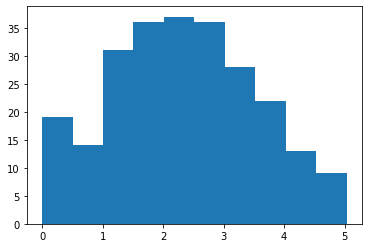

In [32]:
plt.hist(np.log(test_df.citations_old+1))

(array([ 6.,  8., 30., 26., 67., 68., 21., 16.,  2.,  1.]),
 array([4.        , 4.56666667, 5.13333333, 5.7       , 6.26666667,
        6.83333333, 7.4       , 7.96666667, 8.53333333, 9.1       ,
        9.66666667]),
 <BarContainer object of 10 artists>)

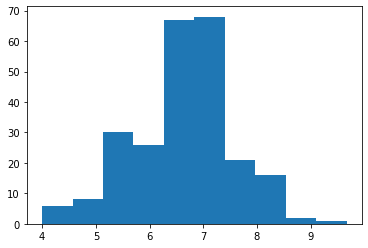

In [34]:
plt.hist(test_df.mean_rating)